In [ ]:
# 自己写出knn的kd树实现
import numpy as np
import heapq
from tqdm import tqdm
from numpy.linalg import norm
class KdNode:
    def __init__(self, point = None, label = None, fi = None, fv = None, left = None, right = None):
        self.point = point
        self.label = label
        self.fi = fi
        self.fv = fv
        self.left = left
        self.right = right

class KdTreeKNN:
    def __init__(self, k=1):
        ''' 
        :param k k值
        :param tree kd树
        '''
        self.k = k
        self.tree = None

    def Build(self, X, y, depth = 0):
        ''' 
        :param X        train set
        :param y        label
        :param depth    depth
        '''
        # 递归终止条件
        if X is None:       # 如果X是空集, not X =1,执行下面的命令.    也可以用 if X is None
            return 
        n_samples, n_features = X.shape
        if n_samples == 1:
            return KdNode(point = X[0], label = y[0])

        fi = depth % n_features
        argsort = 
        
         # 按选定的fi坐标轴取出元素
        idx_middle = argsort[n_samples // 2]
        idxs_left = argsort[:n_samples // 2] # 左闭右开
        idxs_right = argsort[n_samples // 2+1:]
        fv = X[idx_middle, fi]

        left, right = None, None
        if len(idxs_left) > 0:
            left = self.Build(X[idxs_left], y[idxs_left], depth + 1)
        if len(idxs_right) > 0:
            right = self.Build(X[idxs_right], y[idxs_right],  depth + 1)
        return KdNode(X[idx_middle], y[idx_middle], fi, fv, left, right)
    
    def fit(self, X, y):
        ''' 
        :param X        train set
        :param y        label
        '''
        self.tree = self.Build(X, y)

    def nearest(self, kdtree, x, k=1, best_k= None):
        '''
        :param kdtree 给定数据集(X,y)生成的kd树
        :param x 要预测的输入数据
        :param k    k值
        :param best_k 要从上次递归中接受, k个
        在kdtree中找到equery的k近邻点
        ''' 
        # 递归终止条件， 放在递归调用之前
        if not kdtree:
            return
        
        tem_distance = norm(x - kdtree.point)
        if best_k is None:
            '''
            best_distance = norm(x - kdtree.point)
            best_point = kdtree.point
            best = [best_distance, best_point]
            best_k.append(best)
            '''
            best_k= [[tem_distance, kdtree.point, kdtree.label]] * k # 凑够k个近邻点
        elif tem_distance < best_k[-1][0]:
            best_k[-1] = [tem_distance, kdtree.point, kdtree.label] # 凑够之后，替换
            best_k.sort(key= lambda x: x[0], reverse= False)  # 按元素的第一个分量升序排列 

        if kdtree.left is None and kdtree.right is None:    # and
            return best_k

        # 在kd树中找出包含x的叶节点
        # （递归）回退找寻其他可能节点
        dx = x[kdtree.fi] - kdtree.fv
        if dx < 0:
            self.nearest(kdtree.left, x, k, best_k)
            if x[kdtree.fi] + best_k[-1][0] > kdtree.fv:
                self.nearest(kdtree.right, x, k, best_k)
        elif dx > 0:
            self.nearest(kdtree.right, x, k, best_k)
            if x[kdtree.fi] - best_k[-1][0] < kdtree.fv :
                self.nearest(kdtree.left, x, k, best_k)
        else:
            self.nearest(kdtree.left, x, k, best_k)
            self.nearest(kdtree.right, x, k, best_k)
        return best_k
    
    def k_nearest(self, x):
        best_k = self.nearest(self.tree, x, self.k, None)
        # best_k_point =  [ best[1:] for best in best_k]  # 列表推导式
        return best_k
    
    def _predict(self,x):
        ''' 
        :param x 是equery的一个输入
        '''
        best_k = self.k_nearest(x)
        labels = [best[2] for best in best_k]
        
        counter={}
        for i in labels:
            counter.setdefault(i,0)
            counter[i] += 1         # i的值 +1
        sort=sorted(counter.items(),key=lambda x:x[1])
        return sort[-1][0]
    
    def predict(self,equery):
        return np.array([self._predict(x) for x in tqdm(equery)])

### 测试KDTree KNN

100%|██████████| 222300/222300 [00:15<00:00, 14308.70it/s]


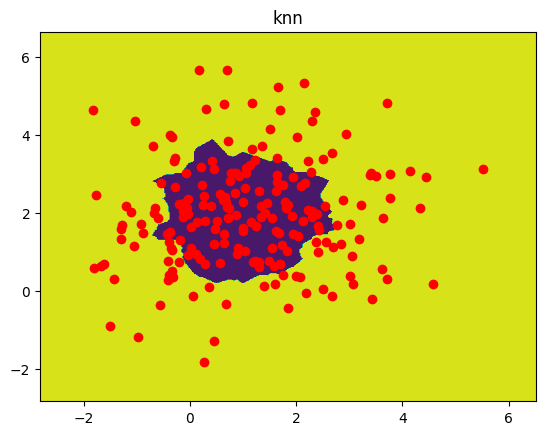

In [15]:
from sklearn.datasets import make_gaussian_quantiles
X, y = make_gaussian_quantiles(n_samples=200, n_features=2, n_classes=2, mean=[1,2],cov=2,random_state=222)
y_neg = y.copy()
y_neg[y==0] = -1

knn = KdTreeKNN(3)
knn.fit(X,y_neg)

import matplotlib.pyplot as plt
%matplotlib inline
def plot_clf(X,y,cls,name):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    points = np.c_[xx.ravel(), yy.ravel()]
    Z = cls.predict(points)
    cs = plt.contourf(xx, yy, Z.reshape(xx.shape))
    plt.scatter(X[:, 0], X[:, 1], marker='o', c='red')
    plt.title(name)

plot_clf(X,y,knn,"knn")

# 普通knn实现

In [16]:
import numpy as np
from tqdm import tqdm 

class KnnClassifier:
    def __init__(self, k=1):
        self.k = k
        
    def k_nearest(self, X, y, x):
        if X is None:
            return 
        distance_point_label = [[np.linalg.norm(x-Xi), Xi, yi] for Xi,yi in zip(X,y)]
        distance_point_label.sort(key= lambda x: x[0]) # 按第一个位置的值升序排列
        best_k = distance_point_label[0:self.k] # 左闭右开
        return best_k

    def _predict(self, X, y, x):
        best_k_label = [best[2] for best in self.k_nearest(X, y, x)]
        counter_dict = {}
        for label in best_k_label:
            counter_dict.setdefault(label,0)
            counter_dict[label] += 1
        counter_dict = sorted(counter_dict.items(), key = lambda x: x[1])
        return counter_dict[-1][0]
    
    def predict(self, X, y, equery):
        return np.array([self._predict(X, y, x) for x in tqdm(equery)])
        

In [17]:
'''X = np.array([[2,3],[5,4],[9,6],[4,7],[8,1],[7,2]])
y = np.array([1,1,-1,-1,1,1])
equery = np.array([[7,10],[4,0],[3,0]])

knnclassifier = KnnClassifier(2)
pre = knnclassifier.predict(X,y,equery)
print(pre)'''


'X = np.array([[2,3],[5,4],[9,6],[4,7],[8,1],[7,2]])\ny = np.array([1,1,-1,-1,1,1])\nequery = np.array([[7,10],[4,0],[3,0]])\n\nknnclassifier = KnnClassifier(2)\npre = knnclassifier.predict(X,y,equery)\nprint(pre)'

100%|██████████| 222300/222300 [02:17<00:00, 1612.19it/s]


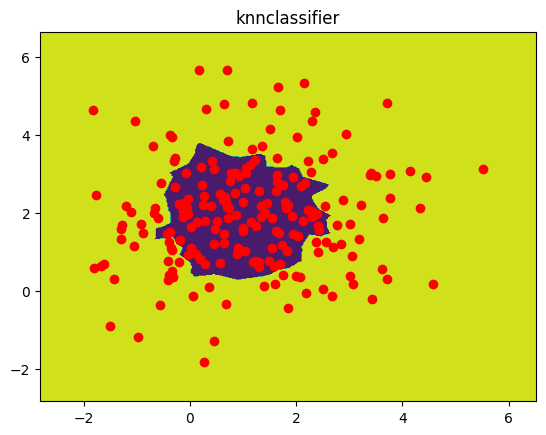

In [18]:
from sklearn.datasets import make_gaussian_quantiles
X, y = make_gaussian_quantiles(n_samples=200, n_features=2, n_classes=2, mean=[1,2],cov=2,random_state=222)
y_neg = y.copy()
y_neg[y==0] = -1

knnclassifier = KnnClassifier()

import matplotlib.pyplot as plt
%matplotlib inline
def plot_clf(X,y,cls,name):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    points = np.c_[xx.ravel(), yy.ravel()]
    Z = cls.predict(X, y, points)
    cs = plt.contourf(xx, yy, Z.reshape(xx.shape))
    plt.scatter(X[:, 0], X[:, 1], marker='o', c='red')
    plt.title(name)

plot_clf(X,y,knnclassifier,"knnclassifier")